![University of Tehran](./img/UT.png)
#   <font color='red'><center>AI CA 3<center></font> 
## <center>Dr. Fadaei<center>
### <center>Daniyal Maroufi<center>
### <center>810098039<center>


## Aim

This assignment aims to use Naive Bayes networks to build a classifier model to predict the category of an article from Digikala using its excerpt.


In [51]:
import math
from collections import defaultdict
import pandas as pd
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import re
from __future__ import unicode_literals
from hazm import *


# Load Data

First, we read the training and test data from csv files.

In [6]:
train_df=pd.read_csv('./Data/train.csv')
test_df=pd.read_csv('./Data/test.csv')
train_df

,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما
...,...,...
5195,امپراطوری اپ (فصل اول/بخش دوم) فصل اول – بخش د...,سلامت و زیبایی
5196,عدم ارتباطات اثربخش و تعارض در محیط کار وجود س...,سلامت و زیبایی
5197,اپل در سال ۲۰۲۰ چهار آیفون معرفی خواهد کرد! طب...,علم و تکنولوژی
5198,مارتینز: بلژیک باید مقابل فرانسه بدون ترس بازی...,سلامت و زیبایی


In [7]:
train_df.isnull().sum()

content    1
label      0
dtype: int64

In [8]:
test_df.isnull().sum()

content    0
label      0
dtype: int64

Because only one sample is null, we simply remove it from the training data.

In [9]:
train_df=train_df.dropna(how='any',axis=0) 

# Phase 1 - Data Preprocessing



In Natural Language Processing, it is agreed that using the root of the words is better for classification accuracy. The prefixes and postfixes of the words are not that necessary to be in sequence, and sometimes they may even inversely affect the accuracy because all forms of a word have the same meaning. For this purpose, there are two methods, Stemming and Lemmatization. Stemming removes the most common prefixes and postfixes of a word to find the root, while, Lemmatization uses an entire dictionary and finds the actual root of the words.

In [10]:
def clean_data(df):
    normalizer = Normalizer()
    lemmatizer = Lemmatizer()
    df['content']=df['content'].apply(lambda x: normalizer.normalize(x))
    df['content']=df['content'].apply(lambda x: word_tokenize(re.sub(r'[^\w\s]', '', x)))
    stp_words=set(stopwords_list())
    df['content']=df['content'].apply(lambda x: [lemmatizer.lemmatize(a) for a in x if a not in stp_words])
    return df

In [11]:
train_df=clean_data(train_df)
test_df=clean_data(test_df)


<ipython-input-10-d3a1f97feef6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content']=df['content'].apply(lambda x: normalizer.normalize(x))
<ipython-input-10-d3a1f97feef6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content']=df['content'].apply(lambda x: word_tokenize(re.sub(r'[^\w\s]', '', x)))
<ipython-input-10-d3a1f97feef6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [12]:
train_df

,content,label
0,"[فیلم, اکران, موزیکال, شاد, خاله, قورباغه, بزر...",هنر و سینما
1,"[فیلمسازی, کوئنتین, تارانتینو, عاشق, سینما, کم...",هنر و سینما
2,"[جان, آیو, اپل, جان, آیو, نیاز, معرف, تقریبا, ...",علم و تکنولوژی
3,"[احتمال, پشتیبان, iOS, ۱۳, آیفون, ۵, اس, SE, آ...",علم و تکنولوژی
4,"[دزد, مغازه, نماینده, ژاپن, اسکار, ۲۰۱۹, فیلم,...",هنر و سینما
...,...,...
5195,"[امپراطوری, اپ, فصل, اولبخش, فصل, دوماپ, گنجین...",سلامت و زیبایی
5196,"[ارتباطات, اثربخش, تعارض, محیط, کار, سازمان, و...",سلامت و زیبایی
5197,"[اپل, سال, ۲۰۲۰, آیفون, معرف, گزارش, JPMorgan,...",علم و تکنولوژی
5198,"[مارتینز, بلژیک, مقابل, فرانسه, ترس, بازی, سرم...",سلامت و زیبایی


# Phase 2 - Problem Procedure

In this assignment, we use the Bag of Words strategy. In this strategy, the position of the words in the sentence is not considered, and only the existence of the words is important. This assumption is not the best one as the order of the words in the sentence is essential too, but on our data, it is good enough to get good accuracy.



The basic formula of the Naive Bayes is shown as bellow:

![Naive Bayes](./img/NaiveBayes.jpg)

where *evidence, likelihood, prior, posterior probabilities, and predictor prior probability* in our problem are:

- The **evidence**(x) is the text input to the model, and the query is the category of the text
- The **posterior probability** is the probability of category(c) concerning given evidence(x). 
- The **likelihood** is the reverse of Posterior probability, the probability of the evidence(x) in category(c).
- The **prior probability** is category(c) probability among all categories.
- The **predictor prior probability** is the probability of the evidence(x) in a general text.

As predictor prior probability is the same for all classes, we only have to compare the nominator, and we can ignore the denominator.

## Mapping Categories to Numbers

To convert categorical columns to numerical, we simply use map() pandas method.

In [13]:
cats=defaultdict(None)
for i, cat in enumerate(train_df['label'].unique()):
    cats[cat]=i
    print(i,' --> ',cat)


0  -->  هنر و سینما
1  -->  علم و تکنولوژی
2  -->  سلامت و زیبایی
3  -->  بازی ویدیویی


In [ ]:
train_df['label']=train_df['label'].map(cats)
test_df['label']=test_df['label'].map(cats)


## Dividing Train Data to Classes

In [39]:
train_df_classes=[]
for i in range(len(cats)):
    train_df_classes.append(train_df.loc[train_df['label'].isin([i])])


## Calculating the Likelihood of the Words

In [40]:
def calc_liklihood(class_df):
    words_prob=defaultdict(lambda: 1)
    for _,row in class_df.iterrows():
        for j in range(len(row['content'])):
            word=row['content'][j]
            words_prob[word]+=1
    num_all_words_class=sum(words_prob.values())
    for word in words_prob:
        words_prob[word]/=num_all_words_class
    return words_prob


In [41]:
class_words_prob=[]
for i in range(len(cats)):
    class_words_prob.append(calc_liklihood(train_df_classes[i]))


In [42]:
n_total_words=0
for class_words in class_words_prob:
    n_total_words+=len(class_words)


## Naive Bayes Classifier 1

In this classifier, we ignore the unseen words in the test data.

In [43]:
def calc_class_prob_1(test_sample, words_prob):
    prob=math.log(1/len(cats))
    test_words_prob=[]
    for word in test_sample:
        if word in words_prob:
            test_words_prob.append(math.log(words_prob[word]))
    prob+=sum(test_words_prob)
    return prob


In [44]:
def classifier_1_predict(test_sample, class_words_prob):
    category_chance=[]
    for i in range(len(cats)):
        class_prob = calc_class_prob_1(test_sample,class_words_prob[i])
        category_chance.append(class_prob)
    return category_chance.index(max(category_chance))


In [45]:
def classifier_1_evaluate(class_words_prob):
    predictions = []
    correct_labels=0
    for _,row in test_df.iterrows():
        prediction=classifier_1_predict(row['content'],class_words_prob)
        predictions.append(prediction)
        if prediction==row['label']:
            correct_labels+=1
    accuracy=correct_labels/test_df.shape[0]
    return predictions, accuracy


In [46]:
_, acc=classifier_1_evaluate(class_words_prob)
print('The accuracy of the model is: ',acc)

The accuracy of the model is:  0.27680798004987534


## Unigram, Bigram, and n-gram

In the previous classifier, we used unigrams, in which we consider the single words independently. But different words may have different meanings together implicitly. Hence, using bigrams and even n-grams helps us better understand the meaning of the expressions in the sentence. For example:
- Why is this so hard to use?
- This glass is hard enough to not be broken.

The word "hard" is in two different sentences with different meanings.

## Additive Smoothing

For example, the word "screen" may be in both the technology and gaming categories. But suppose it is present in a gaming article in the training data and not in a technology one. As a result, the classifier assumes that this word belongs to a gaming class that is not valid in practice. So, as the word "screen" is not present in the technology class, its probability is zero, in this case, minus infinity because of the logarithm. Therefore, other words that may have a good probability in the technology class be eliminated, and the sentence's probability would be zero for that particular class.
- (Class Gaming in train data) The Game plays well on all screen resolutions.
- (Class Technology in test data) The brand new mobile phone has a great touch screen.

If a word did not exist in our training data, it would get the probability of log(0), which is minus infinity, and that class's likelihood of being the one would be almost zero. Therefore by applying the additive smoothing, we ensure that the probability never will be minus infinity. So, for the above particular sentence, the likelihood of classifying the second sentence as technology would be considerable.

In statistics, additive smoothing, or Lidstone smoothing, is a technique used to smooth categorical data.
Given an observation x = (x1, …, xd) from a multinomial distribution with N trials and parameter vector θ = (θ1, …, θd), a "smoothed" version of the data gives the estimator:

![Additive Smoothing](./img/AdditiveSmoothing.png)

where the pseudo count α > 0 is the smoothing parameter (α = 0 corresponds to no smoothing), additive smoothing is a shrinkage estimator, as the resulting estimate will be between the empirical estimate xi / N and the uniform probability 1/d. Using Laplace's rule of succession, some authors have argued that α should be 1 (in which case the term add-one smoothing is also used), though, in practice, a smaller value is typically chosen ([Source](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf)).


In [47]:
def calc_class_prob_2(test_sample, words_prob):
    prob=math.log(1/len(cats))
    test_words_prob=[]
    alpha=1
    for word in test_sample:
        if word in words_prob:
            test_words_prob.append(math.log(words_prob[word]))
        else:
            test_words_prob.append(math.log(alpha/n_total_words))
    prob+=sum(test_words_prob)
    return prob


In [48]:
def classifier_2_predict(test_sample, class_words_prob):
    category_chance=[]
    for i in range(len(cats)):
        class_prob = calc_class_prob_2(test_sample,class_words_prob[i])
        category_chance.append(class_prob)
    return category_chance.index(max(category_chance))


In [49]:
def classifier_2_evaluate(class_words_prob):
    predictions = []
    correct_labels=0
    for _,row in test_df.iterrows():
        prediction=classifier_2_predict(row['content'],class_words_prob)
        predictions.append(prediction)
        if prediction==row['label']:
            correct_labels+=1
    accuracy=correct_labels/test_df.shape[0]
    return predictions, accuracy


In [50]:
_, acc=classifier_2_evaluate(class_words_prob)
print('The accuracy of the model is: ',acc)


The accuracy of the model is:  0.9588528678304239


## Most Common Words

In [52]:
def _(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))


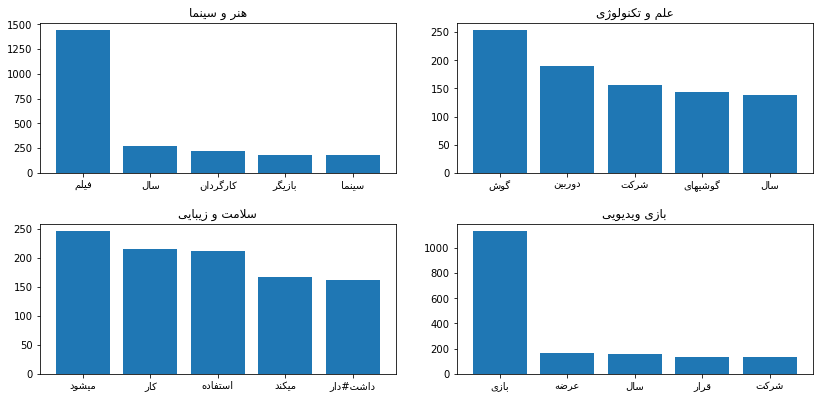

In [78]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 6)
fig.tight_layout(pad=3.0)
for i in range(2):
  for j in range(2):
    key_index = 2*i + j
    cat_words = [(a,b) for a,b in class_words_prob[key_index].items()]
    sorted_words = dict(sorted(cat_words, key=lambda item: item[1], reverse=True))
    words = list(sorted_words.keys())[0:5]
    counts = [int(a*len(cat_words)) for a in list(sorted_words.values())[0:5]]
    axs[i, j].bar([_(a) for a in words], counts)
    axs[i, j].set_title(_([a[0] for a in cats.items() if a[1]==key_index][0]))
plt.show()


## Phase 3 - Evaluation



The formula of precision, recall, and F1 score is shown bellow.

![Evaulation](./img/evaluation.jpg)

In [97]:
def calculate_precision_recall_F1(true_labels, predicted_labels, the_class):
    precision=0
    recall=0
    F1=0

    true_positives=0
    for i in range(len(predicted_labels)):
        if true_labels[i]==predicted_labels[i] and predicted_labels[i]==the_class:
                true_positives+=1

    all_detected_class=0
    for predicted_label in predicted_labels:
        if predicted_label==the_class:
            all_detected_class+=1

    total_class=0
    for true_label in true_labels:
        if true_label==the_class:
            total_class+=1

    precision=true_positives/all_detected_class
    recall=true_positives/total_class
    F1=2*((precision*recall)/(precision+recall))

    return precision, recall, F1

In [94]:
print('Classifier without Additive Smoothing')
predictions, acc=classifier_1_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
for cat,i in cats.items():
    print('For Class:',cat)
    precision,recall,F1=calculate_precision_recall_F1(test_labels,predictions,i)
    print("precision:",precision,"\trecall: ",recall,"\tF1",F1)
    print()


Classifier without Additive Smoothing
For Class: هنر و سینما
precision: 0.18947368421052632 	recall:  0.10778443113772455 	F1 0.13740458015267176

For Class: علم و تکنولوژی
precision: 0.3962765957446808 	recall:  0.5379061371841155 	F1 0.45635528330781006

For Class: سلامت و زیبایی
precision: 0.26126126126126126 	recall:  0.18012422360248448 	F1 0.21323529411764705

For Class: بازی ویدیویی
precision: 0.11818181818181818 	recall:  0.1319796954314721 	F1 0.12470023980815349



In [96]:
print('Classifier with Additive Smoothing')
predictions, acc=classifier_2_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
for cat,i in cats.items():
    print('For Class:',cat)
    precision,recall,F1=calculate_precision_recall_F1(test_labels,predictions,i)
    print("precision:",precision,"\trecall: ",recall,"\tF1",F1)
    print()


Classifier with Additive Smoothing
For Class: هنر و سینما
precision: 0.9585798816568047 	recall:  0.9700598802395209 	F1 0.9642857142857144

For Class: علم و تکنولوژی
precision: 0.950354609929078 	recall:  0.9675090252707581 	F1 0.9588550983899822

For Class: سلامت و زیبایی
precision: 0.9447852760736196 	recall:  0.9565217391304348 	F1 0.9506172839506172

For Class: بازی ویدیویی
precision: 0.9840425531914894 	recall:  0.9390862944162437 	F1 0.961038961038961



### Precision and Recall

Precision can be thought of as a measure of a classifier's exactness. A low precision can also indicate many False Positives, while recall can be thought of as a measure of a classifier's completeness. A low recall means many False Negatives.

In our case, For the class Art and Cinema, the recall is more than precision, which means the classifier has more false positives than false negatives. It can be concluded that there is a feature that has a significant probability in this class, while it is present in other classes too. Hence, the model's precision decreases.

### F1 Score

F1 score conveys the balance between the precision and the recall. The F1 score is the **harmonic mean** of precision and recall. The more general $F_\beta$ score applies additional weights, valuing one for precision or recall more than the other. The highest possible value of the F-score is 1.0, indicating perfect precision and recall, and its lowest possible value is 0.0 if either the precision or the recall is zero.

[Source](https://en.wikipedia.org/wiki/F-score)

### Micro- and Macro- Average

![Micro and Macro Average](./img/micro-macro-avg.png)

As you can see in the above table, we have broadly two types of metrics- micro-average & macro-average, we will discuss the pros and cons of each. Most commonly used metrics for multi-classes are F1 score, Average Accuracy, Log-loss.

![Log-loss](./img/logloss.png)

[Source](https://www.sciencedirect.com/science/article/abs/pii/S0306457309000259)

- In Micro-average method, we sum up the individual true positives, false positives, and false negatives of the system for different sets and then apply them to get the statistics.
- In Macro-average, we take the average of the precision and recall of the system on different sets.

Micro-average is preferable if there is a class imbalance problem.

### Micro-, Macro-, and Weighted- Average F1 Score

Micro-average F1 Score is Relations between data’s positive labels and those given by a classifier based on sums of per-text decisions.

Macro-average F1 Score is Relations between data’s positive labels and those given by a classifier based on a per-class average.

In the weighted-average F1 score, we weigh the F1 score of each class by the number of samples from that class.

[Source](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f)

In [100]:
def calculate_micro_precision_recall_F1(true_labels, predicted_labels):
    precision=0
    recall=0
    F1=0

    all_true_positives=0
    for i in range(len(predicted_labels)):
        if true_labels[i]==predicted_labels[i]:
                all_true_positives+=1

    all_detected_class=0
    for the_class in range(len(cats)):
        for predicted_label in predicted_labels:
            if predicted_label==the_class:
                all_detected_class+=1

    total_class=0
    for the_class in range(len(cats)):
        for true_label in true_labels:
            if true_label==the_class:
                total_class+=1

    precision=all_true_positives/all_detected_class
    recall=all_true_positives/total_class
    F1=2*((precision*recall)/(precision+recall))

    return precision, recall, F1

In [102]:
print('Classifier without Additive Smoothing')
predictions,acc=classifier_1_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_micro_precision_recall_F1(test_labels,predictions)
print("Micro-precision:",precision,"\tMicro-recall: ",recall,"\tMicro-F1",F1)


Classifier without Additive Smoothing
Micro-precision: 0.27680798004987534 	Micro-recall:  0.27680798004987534 	Micro-F1 0.27680798004987534


In [103]:
print('Classifier with Additive Smoothing')
predictions,acc=classifier_2_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_micro_precision_recall_F1(test_labels,predictions)
print("Micro-precision:",precision,"\tMicro-recall: ",recall,"\tMicro-F1",F1)


Classifier with Additive Smoothing
Micro-precision: 0.9588528678304239 	Micro-recall:  0.9588528678304239 	Micro-F1 0.9588528678304239


In [105]:
def calculate_macro_precision_recall_F1(true_labels, predicted_labels):
    precision=0
    recall=0
    F1=0
    for _,i in cats.items():
        p,r,f=calculate_precision_recall_F1(true_labels,predicted_labels,i)
        precision+=p
        recall+=r
        F1+=f
    precision/=len(cats)
    recall/=len(cats)
    F1/=len(cats)
    
    return precision, recall, F1


In [106]:
print('Classifier without Additive Smoothing')
predictions,acc=classifier_1_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_macro_precision_recall_F1(test_labels,predictions)
print("Macro-precision:",precision,"\tMacro-recall: ",recall,"\tMacro-F1",F1)


Classifier without Additive Smoothing
Macro-precision: 0.24129833984957164 	Macro-recall:  0.23944862183894916 	Macro-F1 0.2329238493465706


In [107]:
print('Classifier with Additive Smoothing')
predictions,acc=classifier_2_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_macro_precision_recall_F1(test_labels,predictions)
print("Macro-precision:",precision,"\tMacro-recall: ",recall,"\tMacro-F1",F1)


Classifier with Additive Smoothing
Macro-precision: 0.9594405802127479 	Macro-recall:  0.9582942347642394 	Macro-F1 0.9586992644163187


In [132]:
def calculate_weighted_precision_recall_F1(true_labels, predicted_labels):
    precision=0
    recall=0
    F1=0

    lbls_df=pd.DataFrame(test_labels)
    weights=[lbls_df.loc[lbls_df.loc[:,0].isin([i])].shape[0] for i in range(len(cats))]

    for _,i in cats.items():
        p,r,f=calculate_precision_recall_F1(true_labels,predicted_labels,i)
        precision+=p*weights[i]
        recall+=r*weights[i]
        F1+=f*weights[i]
    precision/=sum(weights)
    recall/=sum(weights)
    F1/=sum(weights)
    
    return precision, recall, F1


In [133]:
print('Classifier without Additive Smoothing')
predictions,acc=classifier_1_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_weighted_precision_recall_F1(test_labels,predictions)
print("Weighted-precision:",precision,"\tWeighted-recall: ",recall,"\tWeighted-F1",F1)


Classifier without Additive Smoothing
Weighted-precision: 0.25780000440064305 	Weighted-recall:  0.27680798004987534 	Weighted-F1 0.25966808972182914


In [134]:
print('Classifier with Additive Smoothing')
predictions,acc=classifier_2_evaluate(class_words_prob)
test_labels=test_df['label'].tolist()
precision,recall,F1=calculate_weighted_precision_recall_F1(test_labels,predictions)
print("Weighted-precision:",precision,"\tWeighted-recall: ",recall,"\tWeighted-F1",F1)


Classifier with Additive Smoothing
Weighted-precision: 0.959224288795034 	Weighted-recall:  0.9588528678304239 	Weighted-F1 0.9588686216714015
